# _Tensorflow implementation of paper "A Neural Algorithm of Artistic Style (2015)_"

#### _This was the breakthrough paper back then 2016. The paper shows that the pretrained convolutional network(such as VGG19) can be used to extract style and content independently from the image. They used these phenomenon to merge the content of a given image with style of reference image. They paper has great visual examples of their results. Here, we are also going to replicate the same._  

##### Step 1: Preprocessing the input image

##### Step 2: Computing the output for selected layers for the content image and all the layers for style image.

##### Step 3: What are loss functions in this problem and computing the loss functions.

_Step 3A: Content Loss for reconstruction of the content image._ 

_Step 3B: Style Loss for reconstruction of the style from a style image irrespective of content placement of the image._
##### Step 4: Creating combined Tensorflow model and Running it to minimize the both the losses and optimize the input noise variable.

##### Step 5: Post processing and displaying the image

##### Step 6: Automating the stuffs

##### Step 7: Plotting the successful results.

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 1: Preprocessing the input image

_Note: Here, we have used VGG16 layer instead of VGG19 layer (which was used in the paper.) but both can perform the job. Also, as suggested by the authors' of the paper, we have used average pooling instead of max pooling.
Here, because we just want to compute output of convolution layers not fully connected layers, we can have any size of input image we want._


In [1]:
import numpy as np
import helper
import tf_helper
import tensorflow as tf
from PIL import Image
from tensorflow_vgg import vgg16_avg_pool
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Fixing the size for the images to be processed

input_w = 256 # width of input image(original image will be scaled down to this width), width of generated image 
input_h = 256 # height of input image(original image will be scaled down to this height), height of generated image

/home/patelmeet2012/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### The "helper.py" will help us preprocess and post process the input image. 

#### The "tf_helper.py" will help us compute all the layers-outputs of a given image from VGG16 network. This values will be used later in the actual session. 

Content File


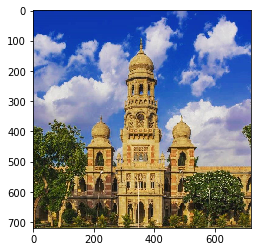

Style File


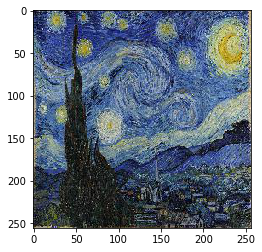

In [2]:
content_file = "./image_resources/content/content_1.jpg"
style_file = "./image_resources/style/style_1.jpg"

output_path = "./image_resources/processed/"

content_output_file = "content_1_processed.jpg"
style_output_file = "style_1_processed.jpg"

# This will scale down the image to given width and height, save it and 
# scale its value to [0-1] as the model expects the input to be between o and 1
# Lastly, it will make a tensorflow ready numpy array with [1, w, h, 3] dims

content_array = helper.resize_and_rescale_img(content_file, input_w, input_h, output_path, content_output_file)
style_array = helper.resize_and_rescale_img(style_file, input_w, input_h, output_path, style_output_file)

i = Image.open(content_file)
j = Image.open(style_file)
print("Content File")
plt.imshow(np.array(i).astype(np.uint8))
plt.show()
print("Style File")
plt.imshow(np.array(j).astype(np.uint8))
plt.show()

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 2: Computing the output for all the layers for the input image. (This will be used later in loss function) 

In [3]:
# Here, we will compute the outputs of all the layers for the given texture image.

content_output = tf_helper.compute_tf_output(content_array)
style_output = tf_helper.compute_tf_output(style_array)

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
All layers' outputs have been computed sucessfully.
/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
All layers' outputs have been computed sucessfully.


##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 3: What are loss function in this problem and computing the loss functions.

#### _Step 3A: Content Loss for reconstruction of the content image._

The content loss is the mean squared difference between feature representation of content image and random noise. The feature representation can be taken from the different layers of the VGG16 model. The each feature representation can be visualized as per below image. Source of the image: https://www.youtube.com/watch?v=CzN_-gVgTno

![](Other resources/Feature representation matrix visualized.PNG)

![](paper/Content Loss.PNG)

Below, we have tried to generate the content of the content image from random noise. As you go throught the results you might notice that as we select deeper layer in VGG16 model the precise representation is getting lost. From initial layers we can generate almost exact image, but as we go deeper the exact detailing is getting lost.

In [37]:
# Only image content reconstruction : Content loss

def content_reconstruction(noise_factor, index, c_output, content_layer_index, name):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    #init_rand = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)
    #init_rand = tf.zeros(shape=content_array.shape)
    init_rand = noise_factor * tf.random_uniform(shape=content_array.shape, minval=0, maxval=1) + (1 - noise_factor) * content_array
    #init_rand = tf.random_uniform(shape=content_array.shape, minval=0.5, maxval=0.5)
    #init_rand = tf.random_normal(shape=content_array.shape, mean=0.5, stddev=0.1)
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers = [vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1, vgg.conv5_1]

    content_part = np.squeeze(c_output[content_layer_index])
    content_part = np.reshape(content_part, (content_part.shape[0] * content_part.shape[1], content_part.shape[2]))

    c_noise_part = tf.squeeze(noise_layers[index])
    c_noise_part = tf.reshape(c_noise_part, (c_noise_part.shape[0] * c_noise_part.shape[1], c_noise_part.shape[2]))
    #content_loss =  tf.reduce_sum((noise_part - content_part)**2) / 2
    # Interestingly, the paper uses this form instead:
    #
    #   0.5 * tf.reduce_sum(tf.pow(x - p, 2)) 
    #
    # But this form is very slow in "painting" and thus could be missing
    # out some constants (from what I see in other source code), so I'll
    # replicate the same normalization constant as used in style loss.
    c_denominator = (4 * c_noise_part.get_shape().as_list()[1] * c_noise_part.get_shape().as_list()[0])
    content_loss =  tf.reduce_sum((c_noise_part - content_part)**2) / tf.cast(c_denominator, tf.float32)

    opt = tf.train.AdamOptimizer().minimize(content_loss)

    epochs = 10000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, content_loss])
            if (i+1) % 1000 == 0:
                print("Epoch: {}/{}, Content Loss: {}".format(i+1, epochs, l))
        final_noise = sess.run(input_noise_variable)
    # post process the output so that it can be represented properly
    # normalized the data for better visualization
    x = helper.post_process_and_display(final_noise, "./image_resources/outputs/", "content_1_" + name + ".jpg")
    return x

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 24.921934127807617
Epoch: 2000/10000, Content Loss: 4.560410022735596
Epoch: 3000/10000, Content Loss: 1.6049199104309082
Epoch: 4000/10000, Content Loss: 0.710038423538208
Epoch: 5000/10000, Content Loss: 0.3517352342605591
Epoch: 6000/10000, Content Loss: 0.19148974120616913
Epoch: 7000/10000, Content Loss: 0.1155768632888794
Epoch: 8000/10000, Content Loss: 0.07727199792861938
Epoch: 9000/10000, Content Loss: 0.05750248581171036
Epoch: 10000/10000, Content Loss: 0.04635637253522873


(-0.5, 255.5, 255.5, -0.5)

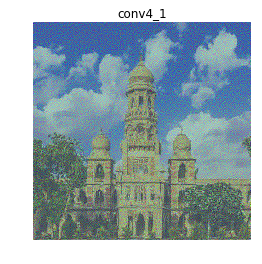

In [38]:
single_content_configs = 10
single_content_config_names = "conv4_1"
noise_g = 0.7
single_content_reconstructions = content_reconstruction(noise_g, 3, content_output, single_content_configs, single_content_config_names)

plt.imshow(single_content_reconstructions)
plt.title(single_content_config_names)
plt.axis('off')

#### Generate output for 5 different configuration - 5 different layers.

In [14]:
content_configs = [0, 3, 6, 10, 14]
content_config_names = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
noise_gamma = 0.7

content_reconstructions = []
for i in range(len(content_configs)):
    print("Computing for layer: ", content_config_names[i])
    op = content_reconstruction(noise_gamma, i, content_output, content_configs[i], content_config_names[i])
    content_reconstructions.append(op)

Computing for layer:  conv1_1
/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 3.7702412605285645
Epoch: 2000/10000, Content Loss: 0.8074206709861755
Epoch: 3000/10000, Content Loss: 0.28692108392715454
Epoch: 4000/10000, Content Loss: 0.12273245304822922
Epoch: 5000/10000, Content Loss: 0.05653814598917961
Epoch: 6000/10000, Content Loss: 0.026479169726371765
Epoch: 7000/10000, Content Loss: 0.012164600193500519
Epoch: 8000/10000, Content Loss: 0.005382005590945482
Epoch: 9000/10000, Content Loss: 0.0022935066372156143
Epoch: 10000/10000, Content Loss: 0.0009548910893499851
Computing for layer:  conv2_1
/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 44.013023376464844
Epoc

#### Visualize the output of different layers

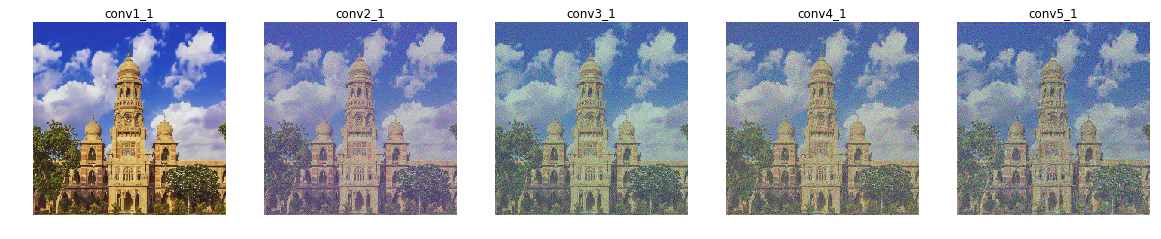

In [15]:
fig = plt.figure(figsize=(20, 20))

cols = len(content_configs)
rows = 1

for j in range(cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(content_reconstructions[j])
    plt.title(content_config_names[j])
    plt.axis('off')

As you can see, the deeper layer we use, the distorted the reconstruction will be. So, it is better to use the initial layers for the reconstruction of the content image. This insight will be used in the further implementation.

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### _Step 3B: Style Loss for reconstruction of the style from a style image irrespective of content placement of the image._

In [24]:
# Only style reconstruction : Style loss

def style_reconstruction(single_config, s_output, name):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    # It has been observed after multiple attempts that minval = 0 and maxval = 0.2 gives better results instead of minval=0 and maxval=1

    init_rand = tf.random_uniform(shape=style_array.shape, minval=0, maxval=1)
    
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })

    style_loss = tf.constant(0, dtype=tf.float32, name="Loss")
    for i in range(len(single_config)):
        style_part = np.squeeze(s_output[single_config[i][0]])
        style_part = np.reshape(style_part, (style_part.shape[0] * style_part.shape[1], style_part.shape[2]))
        style_gram_matrix = np.matmul(style_part.T, style_part)

        s_noise_part = tf.squeeze(noise_layers_list[single_config[i][0]])
        s_noise_part = tf.reshape(s_noise_part, (s_noise_part.shape[0] * s_noise_part.shape[1], s_noise_part.shape[2]))
        noise_gram_matrix = tf.matmul(tf.transpose(s_noise_part), s_noise_part)
        
        s_denominator = (4 * (s_noise_part.get_shape().as_list()[1]**2) * (s_noise_part.get_shape().as_list()[0]**2))
        
        style_loss += single_config[i][1] * tf.reduce_sum((noise_gram_matrix - style_gram_matrix)**2) / tf.cast(s_denominator, tf.float32)
        
    style_loss = style_loss / len(single_config)
    
    opt = tf.train.AdamOptimizer().minimize(style_loss)

    epochs = 10000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, style_loss])
            if (i+1) % 1000 == 0:
                print("Epoch: {}/{}, Style Loss: {}".format(i+1, epochs, l))
        final_noise = sess.run(input_noise_variable)
    # post process the output so that it can be represented properly
    # normalized the data for better visualization
    x = helper.post_process_and_display(final_noise, "./image_resources/outputs/", "style_1_" + name + ".jpg")
    return x 

#### Generate output for 5 different configuration as per paper.

In [25]:
style_configs = [[(0, 1)], [(0, 1), (3, 1)], [(0, 1), (3, 1), (6, 1)], [(0, 1), (3, 1), (6, 1), (10, 1)], [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]]
style_config_names = ["conv1_1", "conv1_1 and conv2_1", "conv1_1, conv2_1 and conv3_1", "conv1_1, conv2_1, conv3_1 and conv4_1", "conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1"]

style_reconstructions = []
for i in range(len(style_configs)):
    print("Computing for configuration: ", style_config_names[i])
    op = style_reconstruction(style_configs[i], style_output, style_config_names[i])
    style_reconstructions.append(op)

Computing for configuration:  conv1_1
/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Loss: 947.48046875
Epoch: 2000/10000, Loss: 67.51200866699219
Epoch: 3000/10000, Loss: 18.35495948791504
Epoch: 4000/10000, Loss: 7.6830644607543945
Epoch: 5000/10000, Loss: 3.782891035079956
Epoch: 6000/10000, Loss: 1.9584708213806152
Epoch: 7000/10000, Loss: 1.0639445781707764
Epoch: 8000/10000, Loss: 0.6126115322113037
Epoch: 9000/10000, Loss: 0.37312790751457214
Epoch: 10000/10000, Loss: 0.2413962036371231
Computing for configuration:  conv1_1 and conv2_1
/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Loss: 444379.6875
Epoch: 2000/10000, Loss: 123190.125
Epoch: 3000/10000, Loss: 53630.50390625
Epoch: 4000/10000,

#### Visualize the output of different layers

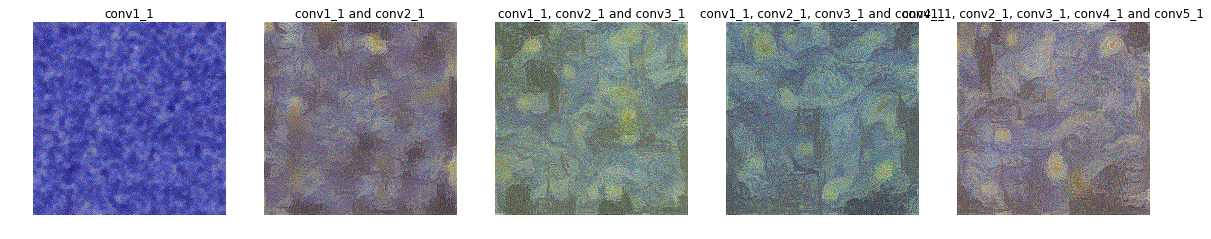

In [26]:
fig_ = plt.figure(figsize=(20, 20))

cols_ = len(style_configs)
rows_ = 1

for j in range(cols_*rows_):
    fig_.add_subplot(rows_, cols_, j+1)
    plt.imshow(style_reconstructions[j])
    plt.title(style_config_names[j])
    plt.axis('off')

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 4: Creating combined Tensorflow model and Running it to minimize the both the losses and optimize the input noise variable.

In [50]:
def style_transfer(noise_factor, style_configurations, content_configurations, s_output, c_output, alpha, beta, f_name):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    # It has been observed after multiple attempts that minval = 0 and maxval = 0.2 gives better results instead of minval=0 and maxval=1

    #init_rand = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)
    #init_rand = tf.random_normal(shape=content_array.shape, mean=0, stddev=1)
    #init_rand = tf.zeros(shape=content_array.shape)
    init_rand = noise_factor * tf.random_uniform(shape=content_array.shape, minval=0, maxval=1) + (1 - noise_factor) * content_array
    
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })
    
    ### Content Loss
    content_part = np.squeeze(c_output[content_configurations])
    content_part = np.reshape(content_part, (content_part.shape[0] * content_part.shape[1], content_part.shape[2]))

    noise_part_c = tf.squeeze(noise_layers_list[content_configurations])
    noise_part_c = tf.reshape(noise_part_c, (noise_part_c.shape[0] * noise_part_c.shape[1], noise_part_c.shape[2]))
    #content_loss =  tf.reduce_sum((noise_part - content_part)**2) / 2
    # Interestingly, the paper uses this form instead:
    #
    #   0.5 * tf.reduce_sum(tf.pow(x - p, 2)) 
    #
    # But this form is very slow in "painting" and thus could be missing
    # out some constants (from what I see in other source code), so I'll
    # replicate the same normalization constant as used in style loss.
    c_denominator = (4 * noise_part_c.get_shape().as_list()[1] * noise_part_c.get_shape().as_list()[0])
    content_loss =  tf.reduce_sum((noise_part_c - content_part)**2) / tf.cast(c_denominator, tf.float32)

    ### Style Loss
    style_loss = tf.constant(0, dtype=tf.float32, name="Loss")
    for i in range(len(style_configurations)):
        style_part = np.squeeze(s_output[style_configurations[i][0]])
        style_part = np.reshape(style_part, (style_part.shape[0] * style_part.shape[1], style_part.shape[2]))
        style_gram_matrix = np.matmul(style_part.T, style_part)

        noise_part_s = tf.squeeze(noise_layers_list[style_configurations[i][0]])
        noise_part_s = tf.reshape(noise_part_s, (noise_part_s.shape[0] * noise_part_s.shape[1], noise_part_s.shape[2]))
        noise_gram_matrix = tf.matmul(tf.transpose(noise_part_s), noise_part_s)

        s_denominator = (4 * (noise_part_s.get_shape().as_list()[1]**2) * (noise_part_s.get_shape().as_list()[0]**2))
        
        style_loss += style_configurations[i][1] * tf.reduce_sum((noise_gram_matrix - style_gram_matrix)**2) / tf.cast(s_denominator, tf.float32)

    style_loss = style_loss / len(style_configurations)
    
    total_loss = alpha * content_loss + beta * style_loss
    
    opt = tf.train.AdamOptimizer(2.0).minimize(total_loss)

    epochs = 10000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, total_loss])
            if (i+1) % 1000 == 0:
                c_l, s_l = sess.run([style_loss, content_loss])
                print("Epoch: {}/{}, Content Loss: {}, Style Loss: {}, Total Loss: {}".format(i+1, epochs, c_l, s_l, l))
        final_noise = sess.run(input_noise_variable)
    # post process the output so that it can be represented properly
    # normalized the data for better visualization
    x = helper.post_process_and_display(final_noise, "./image_resources/outputs/",f_name + ".jpg")
    return x 

Now lets reconstruct the results of the paper using as per the configuration provided in the paper

Content loss calculated on conv4_2 layer in VGG19

Style loss calculated on conv1_1, conv2_1, conv3_1, conv4_1 ad conv5_1 with weights = 1/5

alpha / beta = 1 x 10-3

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 276834.90625, Style Loss: 2025.443359375, Total Loss: 277419168.0
Epoch: 2000/10000, Content Loss: 65352.625, Style Loss: 2082.8935546875, Total Loss: 65440272.0
Epoch: 3000/10000, Content Loss: 29510.140625, Style Loss: 2118.71533203125, Total Loss: 29549508.0
Epoch: 4000/10000, Content Loss: 18027.357421875, Style Loss: 2152.0283203125, Total Loss: 18055830.0
Epoch: 5000/10000, Content Loss: 13003.013671875, Style Loss: 2177.992919921875, Total Loss: 13028404.0
Epoch: 6000/10000, Content Loss: 10133.8505859375, Style Loss: 2200.517578125, Total Loss: 10158139.0
Epoch: 7000/10000, Content Loss: 8260.2373046875, Style Loss: 2217.14599609375, Total Loss: 8282015.5
Epoch: 8000/10000, Content Loss: 7022.96240234375, Style Loss: 2230.67236328125, Total Loss: 7052917.5
Epoch: 9000/10000,

(-0.5, 255.5, 255.5, -0.5)

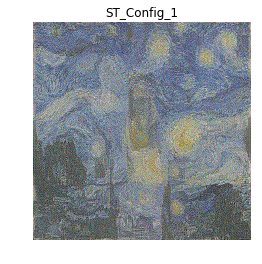

In [46]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 11
noise_f = 0.7
file_name = "ST_Config_1"

style_transfer_outputs = style_transfer(noise_f, style_transfer_config, content_transfer_config, style_output, content_output, 10, 1000, file_name)

plt.imshow(style_transfer_outputs)
plt.title(file_name)
plt.axis('off')

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 280058.34375, Style Loss: 27834.931640625, Total Loss: 280664448.0
Epoch: 2000/10000, Content Loss: 64925.375, Style Loss: 28743.078125, Total Loss: 65021056.0
Epoch: 3000/10000, Content Loss: 29519.51953125, Style Loss: 29335.447265625, Total Loss: 29566784.0
Epoch: 4000/10000, Content Loss: 18166.57421875, Style Loss: 29817.330078125, Total Loss: 18203480.0
Epoch: 5000/10000, Content Loss: 13058.0078125, Style Loss: 30233.87890625, Total Loss: 13091970.0
Epoch: 6000/10000, Content Loss: 10088.0693359375, Style Loss: 30647.98046875, Total Loss: 10121066.0
Epoch: 7000/10000, Content Loss: 8152.87255859375, Style Loss: 31023.880859375, Total Loss: 8189868.0
Epoch: 8000/10000, Content Loss: 6819.73046875, Style Loss: 31321.728515625, Total Loss: 6854034.5
Epoch: 9000/10000, Content Lo

(-0.5, 255.5, 255.5, -0.5)

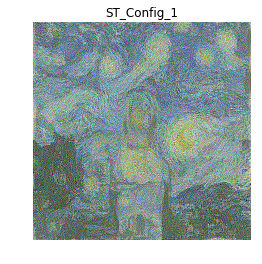

In [47]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 8
noise_f = 0.7
file_name = "ST_Config_1"

style_transfer_outputs = style_transfer(noise_f, style_transfer_config, content_transfer_config, style_output, content_output, 1, 1000, file_name)

plt.imshow(style_transfer_outputs)
plt.title(file_name)
plt.axis('off')

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 278377.53125, Style Loss: 11352.0390625, Total Loss: 2789541888.0
Epoch: 2000/10000, Content Loss: 62794.90625, Style Loss: 12115.0078125, Total Loss: 628617280.0
Epoch: 3000/10000, Content Loss: 28401.412109375, Style Loss: 12507.115234375, Total Loss: 284195136.0
Epoch: 4000/10000, Content Loss: 17797.07421875, Style Loss: 12814.146484375, Total Loss: 178050560.0
Epoch: 5000/10000, Content Loss: 12935.4931640625, Style Loss: 13080.2138671875, Total Loss: 129403568.0
Epoch: 6000/10000, Content Loss: 10104.6796875, Style Loss: 13353.3095703125, Total Loss: 101082896.0
Epoch: 7000/10000, Content Loss: 8211.4638671875, Style Loss: 13628.7724609375, Total Loss: 82142696.0
Epoch: 8000/10000, Content Loss: 6930.3671875, Style Loss: 13889.1298828125, Total Loss: 69328824.0
Epoch: 9000/100

(-0.5, 255.5, 255.5, -0.5)

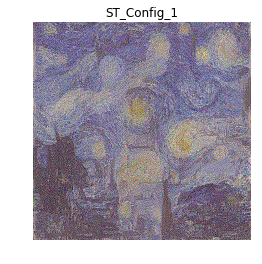

In [48]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 1
noise_f = 0.7
file_name = "ST_Config_1"

style_transfer_outputs = style_transfer(noise_f, style_transfer_config, content_transfer_config, style_output, content_output, 1, 10000, file_name)

plt.imshow(style_transfer_outputs)
plt.title(file_name)
plt.axis('off')

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 274632.09375, Style Loss: 27972.52734375, Total Loss: 277990592.0
Epoch: 2000/10000, Content Loss: 65244.78125, Style Loss: 28664.205078125, Total Loss: 68177304.0
Epoch: 3000/10000, Content Loss: 29331.494140625, Style Loss: 29080.439453125, Total Loss: 32257698.0
Epoch: 4000/10000, Content Loss: 17813.2890625, Style Loss: 29378.81640625, Total Loss: 20758216.0
Epoch: 5000/10000, Content Loss: 12839.01171875, Style Loss: 29608.978515625, Total Loss: 15803502.0
Epoch: 6000/10000, Content Loss: 10036.1708984375, Style Loss: 29795.349609375, Total Loss: 13017902.0
Epoch: 7000/10000, Content Loss: 8243.095703125, Style Loss: 29951.517578125, Total Loss: 11238514.0
Epoch: 8000/10000, Content Loss: 7044.86962890625, Style Loss: 30054.798828125, Total Loss: 10052283.0
Epoch: 9000/10000, C

(-0.5, 255.5, 255.5, -0.5)

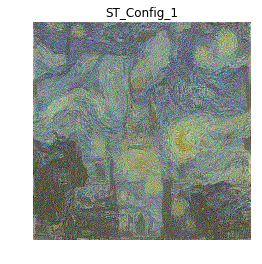

In [49]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 8
noise_f = 0.7
file_name = "ST_Config_1"

style_transfer_outputs = style_transfer(noise_f, style_transfer_config, content_transfer_config, style_output, content_output, 100, 1000, file_name)

plt.imshow(style_transfer_outputs)
plt.title(file_name)
plt.axis('off')

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Content Loss: 6981243.5, Style Loss: 41732.62109375, Total Loss: 6994442240.0
Epoch: 2000/10000, Content Loss: 2057655.625, Style Loss: 42042.6328125, Total Loss: 2064249856.0
Epoch: 3000/10000, Content Loss: 683821.5, Style Loss: 41796.35546875, Total Loss: 688702272.0
Epoch: 4000/10000, Content Loss: 286936.78125, Style Loss: 41363.1875, Total Loss: 291281856.0
Epoch: 5000/10000, Content Loss: 151894.5625, Style Loss: 41035.8515625, Total Loss: 156084096.0
Epoch: 6000/10000, Content Loss: 91760.9921875, Style Loss: 40861.84765625, Total Loss: 95889216.0
Epoch: 7000/10000, Content Loss: 60915.98828125, Style Loss: 40693.70703125, Total Loss: 65008212.0
Epoch: 8000/10000, Content Loss: 42619.6484375, Style Loss: 40487.671875, Total Loss: 46682768.0
Epoch: 9000/10000, Content Loss: 30912.5625, Sty

(-0.5, 255.5, 255.5, -0.5)

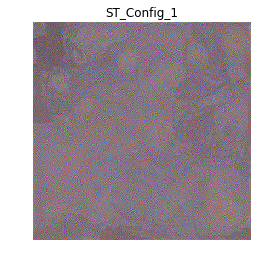

In [51]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 8
noise_f = 0.7
file_name = "ST_Config_1"

style_transfer_outputs = style_transfer(noise_f, style_transfer_config, content_transfer_config, style_output, content_output, 100, 1000, file_name)

plt.imshow(style_transfer_outputs)
plt.title(file_name)
plt.axis('off')

In [ ]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 8
noise_f = 0.7
file_name = "ST_Config_1"

style_transfer_outputs = style_transfer(noise_f, style_transfer_config, content_transfer_config, style_output, content_output, 100, 100000, file_name)

plt.imshow(style_transfer_outputs)
plt.title(file_name)
plt.axis('off')

In [ ]:
np.array(content_outputs[0]).shape

In [ ]:
from tensorflow_vgg import vgg16_avg_pool
tf.reset_default_graph()

vgg = vgg16_avg_pool.Vgg16()

#random_ = tf.truncated_normal(shape=content_array.shape, mean=0.5, stddev=0.5)
random_ = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)

input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)

vgg.build(input_noise)

noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })
""""
# CONTENT LOSS
#def myfxn(m):
    # layer no 11 = conv4_2_7
m = 8

a = tf.squeeze(noise_layers_list[m], 0)
a = tf.reshape(a, shape=(a.shape[0]*a.shape[1], a.shape[2]))

b = np.squeeze(content_outputs[m], 0)
b = np.reshape(b, newshape=(b.shape[0]*b.shape[1], b.shape[2]))
content_loss = tf.reduce_mean((tf.square(tf.subtract(a, b)))/2)
opt = tf.train.AdamOptimizer().minimize(content_loss)
#    return opt

"""    

"""
Style cost

m = 13 # upto layer 5 (excluding layer 5) we want style cost to be calculated
loss = tf.constant(0, dtype=tf.float32, name="Loss")
for i in range(m):
    style_filters = np.squeeze(content_outputs[i], 0)
    style_filters = np.reshape(style_filters, newshape=(style_filters.shape[0] * style_filters.shape[1], style_filters.shape[2]))
    gram_matrix_style = np.matmul(style_filters.T, style_filters)
    
    noise_filters = tf.squeeze(noise_layers_list[i], 0)
    noise_filters = tf.reshape(noise_filters, shape=(noise_filters.shape[0] * noise_filters.shape[1], noise_filters.shape[2]))
    gram_matrix_noise = tf.matmul(tf.transpose(noise_filters), noise_filters)
    
    denominator = (4 * tf.convert_to_tensor(style_filters.shape[1], dtype=tf.float32) * tf.convert_to_tensor(style_filters.shape[0], dtype=tf.float32))
    loss += tf.reduce_sum(tf.square(tf.subtract(gram_matrix_style, gram_matrix_noise))) / tf.cast(denominator, tf.float32)

optimizer = tf.train.AdamOptimizer().minimize(loss)
"""


m = [2, 5, 9, 13]
loss = tf.constant(0, dtype=tf.float32, name="Loss")
for i in range(len(m)):
    style_filters = np.squeeze(content_outputs[m[i]], 0)
    style_filters = np.reshape(style_filters, newshape=(style_filters.shape[0] * style_filters.shape[1], style_filters.shape[2]))
    gram_matrix_style = np.matmul(style_filters.T, style_filters)
    
    noise_filters = tf.squeeze(noise_layers_list[m[i]], 0)
    noise_filters = tf.reshape(noise_filters, shape=(noise_filters.shape[0] * noise_filters.shape[1], noise_filters.shape[2]))
    gram_matrix_noise = tf.matmul(tf.transpose(noise_filters), noise_filters)
    
    denominator = (4 * tf.convert_to_tensor(style_filters.shape[1], dtype=tf.float32) * tf.convert_to_tensor(style_filters.shape[0], dtype=tf.float32))
    loss += 1e-9 * tf.reduce_sum(tf.square(tf.subtract(gram_matrix_style, gram_matrix_noise))) / tf.cast(denominator, tf.float32)

optimizer = tf.train.AdamOptimizer().minimize(loss)


epochs = 25000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(tf.trainable_variables())
    init_noise = sess.run(input_noise)
    for i in range(epochs):
        _, s_loss = sess.run([optimizer, loss])
        if (i+1) % 100 == 0:
            print("Epoch: {}/{}".format(i+1, epochs), " Loss: ", s_loss)
    final_noise = sess.run(input_noise)

In [ ]:
from PIL import Image
f = np.squeeze(final_noise)
final_noise_array = (f - f.min() ) / (f.max() - f.min())
    
img = Image.fromarray(final_noise_array, mode='RGB')
img.show()

In [ ]:
initial_noise = helper.post_process_and_display(init_noise, "5_initial_noise.jpg")
final_noise_ = helper.post_process_and_display(final_noise, "5_final_noise.jpg")

In [ ]:
import winsound
duration = 2000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

In [ ]:
winsound.Beep(freq, duration)